In [15]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from process1 import features_tsfel
from datetime import timedelta
from sklearn.metrics import confusion_matrix


ImportError: cannot import name 'features_tsfel' from 'process1' (c:\Users\julia\.vscode\PIBIC\Toyproblem\toyproblem1\process1.py)

In [11]:
df_filt = pd.read_csv('df_raw.csv')
df_test = pd.read_csv('df_test.csv')   
df_filt['Timestamp'] = pd.to_datetime(df_filt['Timestamp'])
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

df_filt.columns

Index(['Timestamp', 'Back.Acc.X', 'Back.Acc.Y', 'Back.Acc.Z', 'Back.Gyr.X',
       'Back.Gyr.Y', 'Back.Gyr.Z', 'Back.Mag.X', 'Back.Mag.Y', 'Back.Mag.Z',
       'Chest.Acc.X', 'Chest.Acc.Y', 'Chest.Acc.Z', 'Chest.Gyr.X',
       'Chest.Gyr.Y', 'Chest.Gyr.Z', 'Chest.Mag.X', 'Chest.Mag.Y',
       'Chest.Mag.Z', 'Neck.Acc.X', 'Neck.Acc.Y', 'Neck.Acc.Z', 'Neck.Gyr.X',
       'Neck.Gyr.Y', 'Neck.Gyr.Z', 'Neck.Mag.X', 'Neck.Mag.Y', 'Neck.Mag.Z',
       'Type', 'Position', 'Breed', 'Subject'],
      dtype='object')

In [12]:
features_filt = features_tsfel(df_filt, w_size=100, w_overlap=0, t_time=timedelta(microseconds=10000), n_jobs=6)

NameError: name 'features_tsfel' is not defined

In [ ]:
features_test = features_tsfel(df_test, w_size=100, w_overlap=0, t_time=timedelta(microseconds=10000), n_jobs=6)

In [ ]:
features_filt_50 = features_tsfel(df_filt, w_size=100, w_overlap=0.5, t_time=timedelta(microseconds=5000), n_jobs=6)

In [ ]:
features_test_50 = features_tsfel(df_test, w_size=100, w_overlap=0.5, t_time=timedelta(microseconds=5000), n_jobs=6)

In [ ]:
# Rename columns ending with '_Mean' by prepending 'mean_'
mapping = {col: 'mean_' + col[:-5] for col in features_filt.columns if col.endswith('_Mean')}
features_filt.rename(columns=mapping, inplace=True)
mapping = {col: 'mean_' + col[:-5] for col in features_filt_50.columns if col.endswith('_Mean')}
features_filt_50.rename(columns=mapping, inplace=True)
mapping = {col: 'mean_' + col[:-5] for col in features_test.columns if col.endswith('_Mean')}
features_test.rename(columns=mapping, inplace=True)
mapping = {col: 'mean_' + col[:-5] for col in features_test_50.columns if col.endswith('_Mean')}
features_test_50.rename(columns=mapping, inplace=True)

# Rename columns ending with 'Standard deviation' by prepending 'std_'
mapping_std = {col: 'std_' + col.replace('Standard deviation', '').rstrip(' _.') for col in features_filt.columns if col.endswith('Standard deviation')}
features_filt.rename(columns=mapping_std, inplace=True)
mapping_std = {col: 'std_' + col.replace('Standard deviation', '').rstrip(' _.') for col in features_test.columns if col.endswith('Standard deviation')}
features_test.rename(columns=mapping_std, inplace=True)
mapping_std = {col: 'std_' + col.replace('Standard deviation', '').rstrip(' _.') for col in features_test_50.columns if col.endswith('Standard deviation')}
features_test_50.rename(columns=mapping_std, inplace=True)
mapping_std = {col: 'std_' + col.replace('Standard deviation', '').rstrip(' _.') for col in features_filt_50.columns if col.endswith('Standard deviation')}
features_filt_50.rename(columns=mapping_std, inplace=True)



In [ ]:
def get_axis(ax:str, dataframe:pd.DataFrame) -> pd.DataFrame: 
    """Filtra o Eixo de um dataframe"""
    dataframe_ax = pd.DataFrame()
    for col in dataframe.columns: 
        if col.endswith(ax):
            dataframe_ax[col] = dataframe[col] 
    return dataframe_ax

def get_axis_mean(ax: str, dataframe: pd.DataFrame) -> pd.DataFrame:
    """Retorna um Dataframe com com a média das médias e dos desvios padrões de um eixo específico"""
    dataframe_ax_mean = pd.DataFrame()
    dataframe_ax_std = pd.DataFrame()

    for col in dataframe: 
        if col.endswith(ax):
            if col.startswith("mean"):
                dataframe_ax_mean[col] = dataframe[col]
            else: 
                dataframe_ax_std[col] = dataframe[col]
    
    dataframe_ax_mean = dataframe_ax_mean.mean(axis = 1 )
    dataframe_ax_std = dataframe_ax_std.mean(axis = 1 )
        
    return pd.DataFrame({f"mean_media_{ax}": dataframe_ax_mean, f"mean_Desviopadrao_{ax}": dataframe_ax_std})

def get_axis_sum(ax: str, dataframe: pd.DataFrame) -> pd.DataFrame: 
    """Faz a soma do desvio padrão que acontece em um eixo em específico"""
    dataframe_ax_std = pd.DataFrame()

    for col in dataframe: 
        if col.endswith(ax):
            if col.startswith("std"):
                dataframe_ax_std[col] = dataframe[col]
            
    dataframe_ax_sum_std = dataframe_ax_std.sum(axis = 1 )

    return pd.DataFrame({f"soma_std_{ax}":dataframe_ax_sum_std})


def get_sensor(sensor: str, dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe_sensor = pd.DataFrame()
    for col in dataframe.columns: 
        if sensor in col: 
            dataframe_sensor[col] = dataframe[col]

    return dataframe_sensor

def df_num(df) -> pd.DataFrame:
    """Retorna um Dataframe apenas com as colunas numéricas"""
    df_numerico = df.select_dtypes(include=[np.number])
    return df_numerico

In [ ]:
standing = features_filt[features_filt["Position"] == "standing"]
conjunto_sensores = pd.Series(features_filt.columns).str.extract(r'^(.*)\.(?:X|Y|Z)')[0].dropna().unique().tolist()
eixos = ("X", "Y", "Z")

dict_sensores = {}

for sensor in conjunto_sensores:
    df_sensor = get_sensor(sensor, standing)
    dict_valores = {}

    for ax in eixos:
        col_df = get_axis(ax, df_sensor)

        # caso 1: não existe esse eixo → col_df vazio
        if col_df is None or len(col_df.columns if isinstance(col_df, pd.DataFrame) else col_df) == 0:
            dict_valores[f"mean_{ax}"] = None
            continue

        # caso 2: veio DataFrame → pegar a primeira coluna
        if isinstance(col_df, pd.DataFrame):
            col_series = col_df.iloc[:, 0]
        else:
            col_series = col_df

        dict_valores[f"mean_{ax}"] = float(col_series.mean())

    dict_sensores[sensor] = dict_valores

print(dict_sensores)

{'mean_Back.Acc': {'mean_X': 0.0618956376699029, 'mean_Y': 0.01379852145631068, 'mean_Z': 0.9869498473786407}, 'std_Back.Acc': {'mean_X': 0.0979174310921173, 'mean_Y': 0.09820910333145062, 'mean_Z': 0.06663172395320706}, 'mean_Back.Gyr': {'mean_X': -1.1458363484466016, 'mean_Y': -0.2317967234951452, 'mean_Z': -3.4489153192233015}, 'std_Back.Gyr': {'mean_X': 16.298904410002837, 'mean_Y': 19.86350777658396, 'mean_Z': 16.936061881382404}, 'mean_Back.Mag': {'mean_X': 19.145834980873786, 'mean_Y': -5.6031028651456305, 'mean_Z': 20.804228862427188}, 'std_Back.Mag': {'mean_X': 1.8688814338028301, 'mean_Y': 1.6277162269854113, 'mean_Z': 1.1976529140977075}, 'mean_Chest.Acc': {'mean_X': -0.2963278394174757, 'mean_Y': 0.06960418611650485, 'mean_Z': -0.9401505459223302}, 'std_Chest.Acc': {'mean_X': 0.10594172786426836, 'mean_Y': 0.12642492604125669, 'mean_Z': 0.09824890567319727}, 'mean_Chest.Gyr': {'mean_X': 1.675557064466019, 'mean_Y': 0.2508280814563108, 'mean_Z': 1.778455706019417}, 'std_Ches

In [ ]:
#============================== FEATURES_FILT ==============================
# For each sensor compute Euclidean distance from its mean (using mean_ columns)
for sensor in conjunto_sensores:
    # get all columns for this sensor and keep only mean_ columns
    df_sensor = get_sensor(sensor, features_filt)
    # keep columns that start with 'mean_' and contain the sensor name
    if df_sensor.shape[1] > 0:
        df_sensor = df_sensor.loc[:, df_sensor.columns.str.startswith('mean_') & df_sensor.columns.str.contains(sensor)]

    dist_euc_sq = pd.Series(0.0, index=features_filt.index)
    for eixo in eixos:
        col_df = get_axis(eixo, df_sensor)
        if col_df is None or (isinstance(col_df, pd.DataFrame) and col_df.shape[1] == 0):
            continue
        if isinstance(col_df, pd.DataFrame):
            col_series = col_df.iloc[:, 0]
        else:
            col_series = col_df
        mean_ref = dict_sensores.get(sensor, {}).get(f"mean_{eixo}", 0.0)
        dist_euc_sq += (col_series - mean_ref) ** 2
    features_filt[f"dist_euc_{sensor}"] = np.sqrt(dist_euc_sq)

# Sum stds per axis (uses columns that start with 'std_' and end with axis)
for eixo in eixos:
    df_axis_sum = get_axis_sum(eixo, features_filt)
    features_filt[f"soma_std_{eixo}"] = df_axis_sum[f"soma_std_{eixo}"]


features_filt.drop(columns=[col for col in features_filt.columns if col.startswith(('dist_euc_std', 'sum_std_std', 'sum_std_mean'))], inplace=True)
print(features_filt.columns)

Index(['mean_Back.Acc.X', 'std_Back.Acc.X', 'mean_Back.Acc.Y',
       'std_Back.Acc.Y', 'mean_Back.Acc.Z', 'std_Back.Acc.Z',
       'mean_Back.Gyr.X', 'std_Back.Gyr.X', 'mean_Back.Gyr.Y',
       'std_Back.Gyr.Y', 'mean_Back.Gyr.Z', 'std_Back.Gyr.Z',
       'mean_Back.Mag.X', 'std_Back.Mag.X', 'mean_Back.Mag.Y',
       'std_Back.Mag.Y', 'mean_Back.Mag.Z', 'std_Back.Mag.Z',
       'mean_Chest.Acc.X', 'std_Chest.Acc.X', 'mean_Chest.Acc.Y',
       'std_Chest.Acc.Y', 'mean_Chest.Acc.Z', 'std_Chest.Acc.Z',
       'mean_Chest.Gyr.X', 'std_Chest.Gyr.X', 'mean_Chest.Gyr.Y',
       'std_Chest.Gyr.Y', 'mean_Chest.Gyr.Z', 'std_Chest.Gyr.Z',
       'mean_Chest.Mag.X', 'std_Chest.Mag.X', 'mean_Chest.Mag.Y',
       'std_Chest.Mag.Y', 'mean_Chest.Mag.Z', 'std_Chest.Mag.Z',
       'mean_Neck.Acc.X', 'std_Neck.Acc.X', 'mean_Neck.Acc.Y',
       'std_Neck.Acc.Y', 'mean_Neck.Acc.Z', 'std_Neck.Acc.Z',
       'mean_Neck.Gyr.X', 'std_Neck.Gyr.X', 'mean_Neck.Gyr.Y',
       'std_Neck.Gyr.Y', 'mean_Neck.Gyr.Z', 

In [ ]:
#============================== FEATURES_TEST ==============================
# For each sensor compute Euclidean distance from its mean (using mean_ columns)
for sensor in conjunto_sensores:
    # get all columns for this sensor and keep only mean_ columns
    df_sensor = get_sensor(sensor, features_test)
    # keep columns that start with 'mean_' and contain the sensor name
    if df_sensor.shape[1] > 0:
        df_sensor = df_sensor.loc[:, df_sensor.columns.str.startswith('mean_') & df_sensor.columns.str.contains(sensor)]

    dist_euc_sq = pd.Series(0.0, index=features_test.index)
    for eixo in eixos:
        col_df = get_axis(eixo, df_sensor)
        if col_df is None or (isinstance(col_df, pd.DataFrame) and col_df.shape[1] == 0):
            continue
        if isinstance(col_df, pd.DataFrame):
            col_series = col_df.iloc[:, 0]
        else:
            col_series = col_df
        mean_ref = dict_sensores.get(sensor, {}).get(f"mean_{eixo}", 0.0)
        dist_euc_sq += (col_series - mean_ref) ** 2
    features_test[f"dist_euc_{sensor}"] = np.sqrt(dist_euc_sq)

# Sum stds per axis (uses columns that start with 'std_' and end with axis)
for eixo in eixos:
    df_axis_sum = get_axis_sum(eixo, features_test)
    features_test[f"soma_std_{eixo}"] = df_axis_sum[f"soma_std_{eixo}"]


features_test.drop(columns=[col for col in features_test.columns if col.startswith(('dist_euc_std', 'sum_std_std', 'sum_std_mean'))], inplace=True)
print(features_test.columns)

Index(['mean_Back.Acc.X', 'std_Back.Acc.X', 'mean_Back.Acc.Y',
       'std_Back.Acc.Y', 'mean_Back.Acc.Z', 'std_Back.Acc.Z',
       'mean_Back.Gyr.X', 'std_Back.Gyr.X', 'mean_Back.Gyr.Y',
       'std_Back.Gyr.Y', 'mean_Back.Gyr.Z', 'std_Back.Gyr.Z',
       'mean_Back.Mag.X', 'std_Back.Mag.X', 'mean_Back.Mag.Y',
       'std_Back.Mag.Y', 'mean_Back.Mag.Z', 'std_Back.Mag.Z',
       'mean_Chest.Acc.X', 'std_Chest.Acc.X', 'mean_Chest.Acc.Y',
       'std_Chest.Acc.Y', 'mean_Chest.Acc.Z', 'std_Chest.Acc.Z',
       'mean_Chest.Gyr.X', 'std_Chest.Gyr.X', 'mean_Chest.Gyr.Y',
       'std_Chest.Gyr.Y', 'mean_Chest.Gyr.Z', 'std_Chest.Gyr.Z',
       'mean_Chest.Mag.X', 'std_Chest.Mag.X', 'mean_Chest.Mag.Y',
       'std_Chest.Mag.Y', 'mean_Chest.Mag.Z', 'std_Chest.Mag.Z',
       'mean_Neck.Acc.X', 'std_Neck.Acc.X', 'mean_Neck.Acc.Y',
       'std_Neck.Acc.Y', 'mean_Neck.Acc.Z', 'std_Neck.Acc.Z',
       'mean_Neck.Gyr.X', 'std_Neck.Gyr.X', 'mean_Neck.Gyr.Y',
       'std_Neck.Gyr.Y', 'mean_Neck.Gyr.Z', 

In [ ]:
#============================== FEATURES_FILT_50 ==============================
# For each sensor compute Euclidean distance from its mean (using mean_ columns)
for sensor in conjunto_sensores:
    # get all columns for this sensor and keep only mean_ columns
    df_sensor = get_sensor(sensor, features_filt_50)
    # keep columns that start with 'mean_' and contain the sensor name
    if df_sensor.shape[1] > 0:
        df_sensor = df_sensor.loc[:, df_sensor.columns.str.startswith('mean_') & df_sensor.columns.str.contains(sensor)]

    dist_euc_sq = pd.Series(0.0, index=features_filt_50.index)
    for eixo in eixos:
        col_df = get_axis(eixo, df_sensor)
        if col_df is None or (isinstance(col_df, pd.DataFrame) and col_df.shape[1] == 0):
            continue
        if isinstance(col_df, pd.DataFrame):
            col_series = col_df.iloc[:, 0]
        else:
            col_series = col_df
        mean_ref = dict_sensores.get(sensor, {}).get(f"mean_{eixo}", 0.0)
        dist_euc_sq += (col_series - mean_ref) ** 2
    features_filt_50[f"dist_euc_{sensor}"] = np.sqrt(dist_euc_sq)

# Sum stds per axis (uses columns that start with 'std_' and end with axis)
for eixo in eixos:
    df_axis_sum = get_axis_sum(eixo, features_filt_50)
    features_filt_50[f"soma_std_{eixo}"] = df_axis_sum[f"soma_std_{eixo}"]


features_filt_50.drop(columns=[col for col in features_filt_50.columns if col.startswith(('dist_euc_std', 'sum_std_std', 'sum_std_mean'))], inplace=True)
print(features_filt_50.columns)

Index(['mean_Back.Acc.X', 'std_Back.Acc.X', 'mean_Back.Acc.Y',
       'std_Back.Acc.Y', 'mean_Back.Acc.Z', 'std_Back.Acc.Z',
       'mean_Back.Gyr.X', 'std_Back.Gyr.X', 'mean_Back.Gyr.Y',
       'std_Back.Gyr.Y', 'mean_Back.Gyr.Z', 'std_Back.Gyr.Z',
       'mean_Back.Mag.X', 'std_Back.Mag.X', 'mean_Back.Mag.Y',
       'std_Back.Mag.Y', 'mean_Back.Mag.Z', 'std_Back.Mag.Z',
       'mean_Chest.Acc.X', 'std_Chest.Acc.X', 'mean_Chest.Acc.Y',
       'std_Chest.Acc.Y', 'mean_Chest.Acc.Z', 'std_Chest.Acc.Z',
       'mean_Chest.Gyr.X', 'std_Chest.Gyr.X', 'mean_Chest.Gyr.Y',
       'std_Chest.Gyr.Y', 'mean_Chest.Gyr.Z', 'std_Chest.Gyr.Z',
       'mean_Chest.Mag.X', 'std_Chest.Mag.X', 'mean_Chest.Mag.Y',
       'std_Chest.Mag.Y', 'mean_Chest.Mag.Z', 'std_Chest.Mag.Z',
       'mean_Neck.Acc.X', 'std_Neck.Acc.X', 'mean_Neck.Acc.Y',
       'std_Neck.Acc.Y', 'mean_Neck.Acc.Z', 'std_Neck.Acc.Z',
       'mean_Neck.Gyr.X', 'std_Neck.Gyr.X', 'mean_Neck.Gyr.Y',
       'std_Neck.Gyr.Y', 'mean_Neck.Gyr.Z', 

In [ ]:
#============================== FEATURES_TEST_50 ==============================
# For each sensor compute Euclidean distance from its mean (using mean_ columns)
for sensor in conjunto_sensores:
    # get all columns for this sensor and keep only mean_ columns
    df_sensor = get_sensor(sensor, features_test_50)
    # keep columns that start with 'mean_' and contain the sensor name
    if df_sensor.shape[1] > 0:
        df_sensor = df_sensor.loc[:, df_sensor.columns.str.startswith('mean_') & df_sensor.columns.str.contains(sensor)]

    dist_euc_sq = pd.Series(0.0, index=features_test_50.index)
    for eixo in eixos:
        col_df = get_axis(eixo, df_sensor)
        if col_df is None or (isinstance(col_df, pd.DataFrame) and col_df.shape[1] == 0):
            continue
        if isinstance(col_df, pd.DataFrame):
            col_series = col_df.iloc[:, 0]
        else:
            col_series = col_df
        mean_ref = dict_sensores.get(sensor, {}).get(f"mean_{eixo}", 0.0)
        dist_euc_sq += (col_series - mean_ref) ** 2
    features_test_50[f"dist_euc_{sensor}"] = np.sqrt(dist_euc_sq)

# Sum stds per axis (uses columns that start with 'std_' and end with axis)
for eixo in eixos:
    df_axis_sum = get_axis_sum(eixo, features_test_50)
    features_test_50[f"soma_std_{eixo}"] = df_axis_sum[f"soma_std_{eixo}"]



features_test_50.drop(columns=[col for col in features_test_50.columns if col.startswith(('dist_euc_std', 'sum_std_std', 'sum_std_mean'))], inplace=True)
print(features_test_50.columns)

Index(['mean_Back.Acc.X', 'std_Back.Acc.X', 'mean_Back.Acc.Y',
       'std_Back.Acc.Y', 'mean_Back.Acc.Z', 'std_Back.Acc.Z',
       'mean_Back.Gyr.X', 'std_Back.Gyr.X', 'mean_Back.Gyr.Y',
       'std_Back.Gyr.Y', 'mean_Back.Gyr.Z', 'std_Back.Gyr.Z',
       'mean_Back.Mag.X', 'std_Back.Mag.X', 'mean_Back.Mag.Y',
       'std_Back.Mag.Y', 'mean_Back.Mag.Z', 'std_Back.Mag.Z',
       'mean_Chest.Acc.X', 'std_Chest.Acc.X', 'mean_Chest.Acc.Y',
       'std_Chest.Acc.Y', 'mean_Chest.Acc.Z', 'std_Chest.Acc.Z',
       'mean_Chest.Gyr.X', 'std_Chest.Gyr.X', 'mean_Chest.Gyr.Y',
       'std_Chest.Gyr.Y', 'mean_Chest.Gyr.Z', 'std_Chest.Gyr.Z',
       'mean_Chest.Mag.X', 'std_Chest.Mag.X', 'mean_Chest.Mag.Y',
       'std_Chest.Mag.Y', 'mean_Chest.Mag.Z', 'std_Chest.Mag.Z',
       'mean_Neck.Acc.X', 'std_Neck.Acc.X', 'mean_Neck.Acc.Y',
       'std_Neck.Acc.Y', 'mean_Neck.Acc.Z', 'std_Neck.Acc.Z',
       'mean_Neck.Gyr.X', 'std_Neck.Gyr.X', 'mean_Neck.Gyr.Y',
       'std_Neck.Gyr.Y', 'mean_Neck.Gyr.Z', 

Acurácia: 0.8998
              precision    recall  f1-score   support

  body shake       0.00      0.00      0.00         4
  lying down       0.00      0.00      0.00         0
     sitting       1.00      0.83      0.91       220
    standing       0.77      1.00      0.87       127
     walking       0.97      0.99      0.98        78

    accuracy                           0.90       429
   macro avg       0.55      0.56      0.55       429
weighted avg       0.92      0.90      0.90       429



c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Use

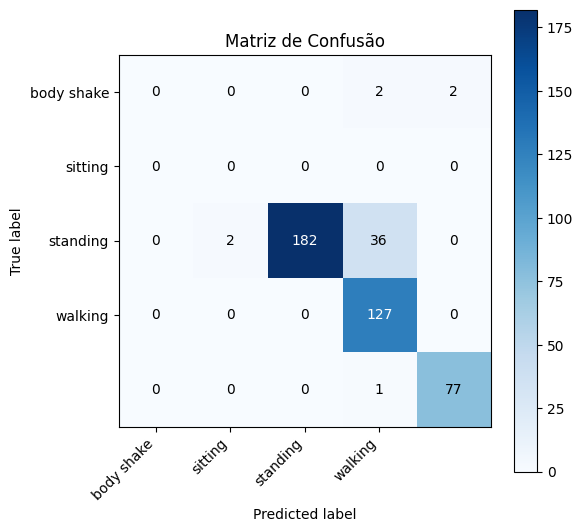

In [ ]:
#============================== RANDOM FOREST SEM OVERLAP ===============================

x_treino = features_filt.drop(columns=["Position", "Subject"])
y_treino = features_filt["Position"]
x_teste = features_test.drop(columns=["Position", "Subject"])
y_teste = features_test["Position"]

rf = RandomForestClassifier(
    n_estimators=300,        # número de árvores
    max_depth=12,          # deixe None inicialmente
    min_samples_split=2,
    min_samples_leaf=1,     # padrão bom para classificação
    bootstrap=True,
    n_jobs=6,
    random_state=42
)

rf.fit(x_treino, y_treino)
y_pred = rf.predict(x_teste)

acc = accuracy_score(y_teste, y_pred)
print(f"Acurácia: {acc:.4f}")

print(classification_report(y_teste, y_pred))

cm = confusion_matrix(y_teste, y_pred)
labels = np.unique(y_teste)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)), xticklabels=labels, yticklabels=labels, ylabel='True label', xlabel='Predicted label', title='Matriz de Confusão')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
plt.show()

Acurácia: 0.8993
              precision    recall  f1-score   support

  body shake       0.00      0.00      0.00         6
     sitting       1.00      0.83      0.91       436
    standing       0.76      0.99      0.86       252
     walking       0.97      0.98      0.97       150

    accuracy                           0.90       844
   macro avg       0.68      0.70      0.68       844
weighted avg       0.91      0.90      0.90       844



c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

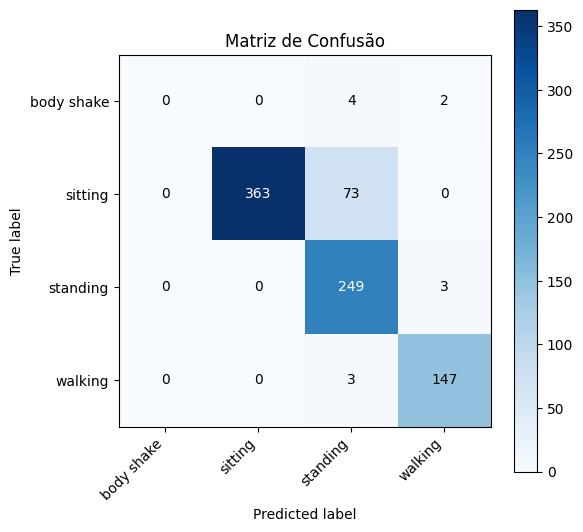

In [ ]:
#============================== RANDOM FOREST COM OVERLAP ===============================

x_treino = features_filt_50.drop(columns=["Position", "Subject"])
y_treino = features_filt_50["Position"]
x_teste = features_test_50.drop(columns=["Position", "Subject"])
y_teste = features_test_50["Position"]

rf = RandomForestClassifier(
    n_estimators=300,        # número de árvores
    max_depth=12,          # deixe None inicialmente
    min_samples_split=2,
    min_samples_leaf=1,     # padrão bom para classificação
    bootstrap=True,
    n_jobs=6,
    random_state=42
)

rf.fit(x_treino, y_treino)
y_pred = rf.predict(x_teste)

acc = accuracy_score(y_teste, y_pred)
print(f"Acurácia: {acc:.4f}")
print(classification_report(y_teste, y_pred))
cm = confusion_matrix(y_teste, y_pred)
labels = np.unique(y_teste)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)), xticklabels=labels, yticklabels=labels, ylabel='True label', xlabel='Predicted label', title='Matriz de Confusão')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Melhor acurácia média (CV): 0.9436914600550965
Acurácia no teste: 0.9360
              precision    recall  f1-score   support

  body shake       0.00      0.00      0.00         6
  lying down       0.00      0.00      0.00         0
     sitting       1.00      0.89      0.94       436
    standing       0.89      0.99      0.94       252
     walking       0.95      1.00      0.97       150

    accuracy                           0.94       844
   macro avg       0.57      0.58      0.57       844
weighted avg       0.95      0.94      0.94       844



c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\julia\.vscode\PIBIC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Use

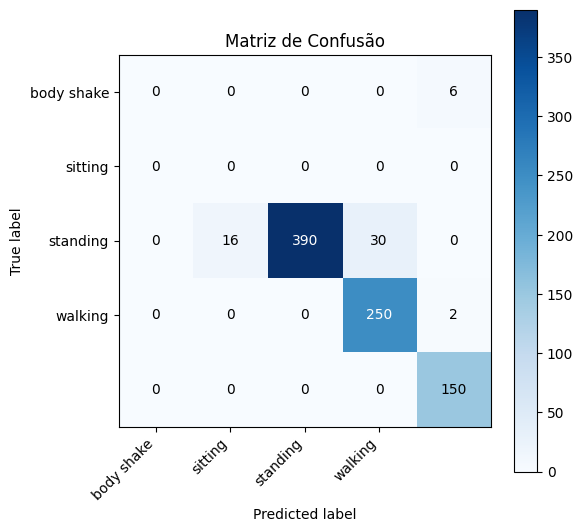

In [ ]:
# Definindo os hiperparâmetros para Grid Search (3 valores para cada)
param_grid = {
    'n_estimators': [50, 100, 20],           # número de árvores
    'max_depth': [5, 6, 10],                # profundidade máxima
    'min_samples_leaf': [1, 2, 5]         # mínimo de amostras por folha
}

# Criando o modelo base ( serão sobrescritos pelo GridSearch)
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    n_jobs=6,
    random_state=42
)

# Grid Search com StratifiedKFold para manter proporção de classes em cada fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=6,
    verbose=2,
    return_train_score=True,
    refit=True
)

# Ajustar o Grid Search no conjunto de treino
grid_search.fit(x_treino, y_treino)

# Resultados
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia média (CV):", grid_search.best_score_)

# Avaliar o melhor estimador no conjunto de teste
rf_best = grid_search.best_estimator_
y_pred = rf_best.predict(x_teste)
acc = accuracy_score(y_teste, y_pred)
print(f"Acurácia no teste: {acc:.4f}")
print(classification_report(y_teste, y_pred))
cm = confusion_matrix(y_teste, y_pred)
labels = np.unique(y_teste)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)), xticklabels=labels, yticklabels=labels, ylabel='True label', xlabel='Predicted label', title='Matriz de Confusão')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
plt.show()
